# M1. Actividad

**Nombre:** Diego Antonio García Padilla.

**Matrícula:** A01710777.

## Descripción del Sistema de 'Recolección de Alimentos'

### Objetivo del Sistema

Desarrollar un sistema donde agentes llamados 'exploradores' buscan comida y la llevan de vuelta a su base. Los exploradores se desplazan buscando celdas con alimentos y regresan a la base una vez que encuentran un recurso.

### Características del Sistema:

- **Energía del Explorador:** Cada explorador comienza con una energía máxima de X unidades, y cada movimiento consume 1 unidad de energía. Al llegar a la base, el explorador recarga completamente su energía.
- **Ubicación de la Base:** La base siempre se encuentra en el centro del área de búsqueda.
- **Parámetros del Sistema:**
  - Un área de NxN celdas.
  - Un número específico de exploradores.
  - Una base fija en una celda determinada.
  - Un número de recursos.
  - Un máximo de energía que los exploradores pueden tener.

### Distribución de Agentes y Recursos:

- Tanto los agentes como los recursos se distribuyen aleatoriamente al inicio de la simulación.

### Comportamiento por Paso:

- Si la celda contiene recursos, el agente los recoge y regresa a la base.
- Si la celda no contiene recursos, el agente elige una dirección aleatoria para moverse (una de las 4 celdas vecinas) a una celda sin otro agente. Si no puede moverse allí, permanecerá en la misma celda.

## Instrucciones para la Simulación y el Análisis:

### Simulación Inicial:

- Ejecuta una simulación para una matriz de 11x11 con 5 exploradores y 20 recursos.
- Todos los agentes deben empezar con 100 unidades de energía.
- Muestra gráficamente el comportamiento del modelo.

### Análisis de Eficiencia:

- Analiza cómo la cantidad de exploradores y recursos influye en la eficiencia de la recolección de recursos.
- La eficiencia se medirá observando la cantidad de energía que cada explorador consume durante el proceso de búsqueda y recolección de recursos.
- Para ello, realiza pruebas en un espacio de 15x15 con:
  - 5 y 10 exploradores.
  - 15, 20 y 30 recursos.
- Presenta los hallazgos en el informe, incluyendo gráficos y tablas según sea necesario.

# Instalación e importación de librerías

In [14]:
# Descargar mesa y seaborn
%pip install mesa seaborn --quiet

Note: you may need to restart the kernel to use updated packages.


In [15]:
# Importamos las clases que se requieren para manejar los agentes (Agent) y su entorno (Model).
# Cada modelo puede contener múltiples agentes.
from mesa import Agent, Model

# Debido a que necesitamos que existe un solo agente por celda, elegimos ''SingleGrid''.
from mesa.space import SingleGrid

# Con ''SimultaneousActivation, hacemos que todos los agentes se activen ''al mismo tiempo''.
from mesa.time import SimultaneousActivation

# Haremos uso de ''DataCollector'' para obtener información de cada paso de la simulación.
from mesa.datacollection import DataCollector

# BATCH_RUNNER
from mesa.batchrunner import batch_run

# matplotlib lo usaremos crear una animación de cada uno de los pasos del modelo.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Importamos los siguientes paquetes para el mejor manejo de valores numéricos.
import numpy as np
import pandas as pd

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime

# Solución 1

- Los agentes se mueven al azar.
- Cuando encuentran comida, buscan el camino a la base.
- Si tienen menos de 20 de energía, regresan a la base.

## Definición de clases de Agente y Modelo

In [16]:
class Explorer(Agent):
    """
    Agente que recolecta comida.
    """

    def __init__(self, id, model, max_energy):
        """
        Constructor de la clase Explorer.
        """

        # Inicializamos la clase padre Agent
        super().__init__(id, model)

        # Atributos del agente
        self.model = model

        # Atributo para guardar la energía máxima del agente
        self.max_energy = max_energy

        # Atributo para guardar la energía del agente
        self.energy = max_energy

        # Atributo para saber si el agente tiene comida
        self.hasFood = False

        # Contador de comida recolectada
        self.foodFound = 0

        # Lista para guardar la eficiencia (cuánta energía gastó en recolectar comida)
        self.efficiency = []

        # Umbral de energía para regresar a la base
        self.energy_threshold = 20  
        

    def move(self):
        """
        Método que define el comportamiento del agente.
        """

        # Obtener las celdas vecinas
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore = False,
            include_center = False)

        # Obtener indices del arreglo de posiciones posibles y desordenarlos
        indexes = [x for x in range(len(possible_steps))]
        np.random.shuffle(indexes)

        # Recorrer las celdas vecinas
        for i in indexes:
            (x, y) = possible_steps[i]

            # Si la celda está vacía y no la han visitado, moverse a ella
            if self.model.grid.is_cell_empty((x, y)):

                # Mover al agente
                self.model.grid.move_agent(self, (x, y))

                # Actualizar la energía
                self.energy -= 1

                break

    def move_to_base(self):
        """
        Método que mueve al agente a la base.
        """

        # Obtener las celdas vecinas
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore = False,
            include_center = False)

        # Obtener posición de la base
        (base_x, base_y) = self.model.base

        # Obtener posición actual del agente
        (x, y) = self.pos

        # Calcular la dirección en la que se moverá el agente
        dx = abs(base_x - x)
        dy = abs(base_y - y)

        # Determinar siguiente posición
        if dx >= dy:
            # Moverse en X
            next_x = x + (1 if base_x > x else -1)
            next_y = y
        else:
            # Moverse en Y
            next_x = x
            next_y = y + (1 if base_y > y else -1)

        # Verificar si la celda a la que se moverá el agente está vacía
        if self.model.grid.is_cell_empty((next_x, next_y)):

            # Mover al agente
            self.model.grid.move_agent(self, (next_x, next_y))

            # Actualizar la energía
            self.energy -= 1
        
    
    def step(self):
        """
        Paso de simulación para el agente.
        """

        # Comprobar si tiene energía
        if self.energy == 0:
            return

        # Obtener la posición actual del agente
        (x, y) = self.pos

        # ¿El agente está en la base?
        if self.model.cells[x][y] == 2:

            # Si el agente tiene comida, dejarla en la base
            if self.hasFood:
                self.hasFood = False
                self.foodFound += 1
                self.model.food += 1

                # Guardar la eficiencia
                self.efficiency.append(self.max_energy - self.energy)

                # Recargar energía
                self.energy = self.max_energy

                # Mover al agente
                self.move()

            else:
                # Recargar energía
                self.energy = self.max_energy
                self.move()
        else:
            # Determinar si debe regresar a la base por baja energía
            if self.energy <= self.energy_threshold:
                self.move_to_base()
            # Si el agente tiene comida, moverse a la base
            elif self.hasFood:
                self.move_to_base()
            else:
                # Comprobar si hay comida en la celda actual
                if self.model.cells[x][y] == 1:
                    # Recolectar la comida
                    self.model.cells[x][y] = 0
                    self.hasFood = True
                    self.move_to_base()
                else:
                    self.move()

In [17]:
def get_grid(model):
    grid = np.zeros((model.grid.width, model.grid.height))
    for content, (x, y) in model.grid.coord_iter():
        grid[x][y] = model.cells[x][y]
        if content != None:
            grid[x][y] = 3
    return grid

In [18]:
class World(Model):
    """
    Modelo del mundo donde los agentes recolectan comida.
    """

    def __init__(self, width = 11, height = 11, num_agents = 5, agents_energy = 100, num_food = 20):
        """
        Constructor de la clase World.
        """

        # Inicializamos la clase padre Model
        super().__init__()

        # Pasos de la simulación
        self.steps = 0

        # Comida recolectada
        self.food = 0

        # Cantidad de comida en el mundo
        self.num_food = 0

        # Grid de la simulación
        self.grid = SingleGrid(width, height, torus = False)

        # Método de activación de los agentes
        self.schedule = SimultaneousActivation(self)

        # Ubicación de la base
        self.base = (width // 2, height // 2)

        # Inicializar celdas
        self.cells = np.zeros((width, height))

        # Agregar comida al mundo
        for _ in range(num_food):

            # Posición aleatoria
            x = np.random.randint(0, width)
            y = np.random.randint(0, height)

            # Comprobar si la celda está vacía
            if self.cells[x][y] == 0:

                # Agregar comida
                self.cells[x][y] = 1

                # Actualizar cantidad de comida
                self.num_food += 1

        # Agregar agentes al mundo
        for i in range(num_agents):
            agent = Explorer(i, self, agents_energy)
            self.schedule.add(agent)
            self.grid.move_to_empty(agent)
        
        # Definir base
        self.cells[self.base[0]][self.base[1]] = 2

        # Recolectar datos
        self.datacollector = DataCollector(
            model_reporters = {
                "Grid": get_grid,
                "Steps": lambda m: m.steps
                },
            agent_reporters = {
                "Efficiency": lambda a: sum(a.efficiency) / len(a.efficiency) if len(a.efficiency) > 0 else 0,
                "FoodFound": lambda a: a.foodFound
                }
        )

    def are_food(self):
        """
        Método que verifica si ya se ha recolectado toda la comida.
        """

        # ¿Se ha recolectado toda la comida?
        are_food = self.food < self.num_food

        return are_food
    
    def are_agents_alive(self):
        """
        Método que verifica si hay agentes vivos en el mundo.
        """

        # ¿Hay agentes con energía?
        are_agents_alive = sum(agent.energy > 0 for agent in self.schedule.agents) > 0

        return are_agents_alive
    
    def game_over(self):
        """
        Método que verifica si la simulación ha terminado.
        """

        # ¿No hay agentes vivos o comida en el mundo?
        return not self.are_agents_alive() or not self.are_food()
    
    def step(self):
        """
        Método que define el comportamiento de los agentes en un paso de la simulación.
        """

        # Comprobar que hay agentes vivos y comida en el mundo
        if not self.game_over():
            self.steps += 1
        
        # Recolectar datos
        self.datacollector.collect(self)

        # Activar a los agentes
        self.schedule.step()

## Simulación

In [19]:
X, Y = 11, 11
AGENTS = 5
AGENTS_ENERGY = 100
FOOD = 20

# Inicializar el modelo
model = World(X, Y, AGENTS, AGENTS_ENERGY, FOOD)

# Ejecutar el modelo
while not model.game_over():
    model.step()

print("Modelo terminado en", model.steps, "pasos")
print("Comida recolectada:", model.food / model.num_food * 100, "%")

Modelo terminado en 103 pasos
Comida recolectada: 100.0 %


In [20]:
all_grids = model.datacollector.get_model_vars_dataframe()
all_grids.head()

,Grid,Steps
0,"[[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1
1,"[[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2
2,"[[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",3
3,"[[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",4
4,"[[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",5


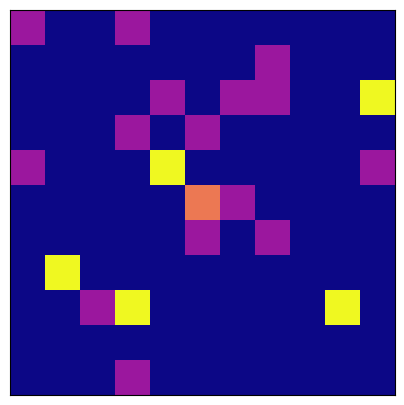

In [21]:
fig, axs = plt.subplots(figsize=(5, 5))
axs.set_xticks([])
axs.set_yticks([])
patch = plt.imshow(all_grids.iloc[0,0], cmap=plt.cm.plasma)

def animate(i):
  patch.set_data(all_grids.iloc[i,0])


anim = animation.FuncAnimation(fig, animate, frames=range(len(all_grids)), repeat=False)

In [22]:
anim

## Análisis

In [23]:
params = {
    "width": 11,
    "height": 11,
    "num_agents": 5,
    "num_food": 20
}

MAX_STEPS = 1000
ITERATIONS = 5

results = batch_run(
    World,
    parameters = params,
    iterations = ITERATIONS,
    max_steps = MAX_STEPS,
    number_processes = 1,
    data_collection_period=1,
    display_progress=True
)

  0%|          | 0/5 [00:00<?, ?it/s]

In [24]:
df = pd.DataFrame(results)
data = df[(df.Step == MAX_STEPS)].drop(
    ['iteration','Step', 'width', 'height', 'num_agents', 'num_food', 'Grid'], 
    axis = 1)

In [25]:
data.head()

,RunId,Steps,AgentID,Efficiency,FoodFound
5000,0,228,0,44.00,2
5001,0,228,1,16.00,8
5002,0,228,2,18.75,4
5003,0,228,3,47.00,4
5004,0,228,4,14.00,1


In [26]:
data.groupby(['AgentID']).agg(['min', 'mean', 'max'])[['Steps', 'FoodFound', 'Efficiency']]

Steps             FoodFound          Efficiency                      
          min   mean  max       min mean max        min       mean        max
AgentID                                                                      
0         148  257.6  347         2  3.0   4  13.000000  29.633333  44.000000
1         148  257.6  347         5  6.0   8  16.000000  20.860000  22.666667
2         148  257.6  347         1  2.8   4   4.666667  15.633333  28.000000
3         148  257.6  347         2  3.2   5   5.500000  18.806667  47.000000
4         148  257.6  347         1  3.8   7   7.000000  14.901429  25.400000